### 1. Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

import time
import random
import copy

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)

### 2. Data Processing

In [3]:
def load_yf(ticker, period="10y", interval="1d"):
    df: pd.DataFrame = yf.Ticker(ticker).history(period=period, interval=interval)
    return df[["Open", "High", "Low", "Close"]], df[["Volume"]]

def normalized(df: pd.DataFrame):
    return (df - df.values.mean()) / df.values.std()

def load_data(ticker):
    price, vol = load_yf(ticker)
    #print("Data size:", len(vol))

    nl_price = normalized(np.log(price))
    n_price = normalized(price)
    n_vol = normalized(vol)

    data = np.concatenate([nl_price, n_price, n_vol], axis=1)
    return data

def load_raw(ticker):
    price, vol = load_yf(ticker)
    data = pd.concat([price, vol], axis=1)
    return data

def process_raw(raw):
    price, vol = raw[["Open", "High", "Low", "Close"]], raw[["Volume"]]

    nl_price = normalized(np.log(price))
    n_price = normalized(price)
    n_vol = normalized(vol)

    data = np.concatenate([nl_price, n_price, n_vol], axis=1)
    return data

def load_label(ticker):
    price, _ = load_yf(ticker)
    close = price[["Close"]].to_numpy()

    change = [0] + [close[i+1]/close[i]-1 for i in range(len(close)-1)]
    label = [0 if change[i] <= 0 else 1 for i in range(len(close))]

    unique, counts = np.unique(label[120:], return_counts=True) 
    #print("Data ratio: ", dict(zip(unique, counts)))
    return label

def split_size(ticker):
    price, _ = load_yf(ticker)
    trainsize = (int) (len(price[120:]) * 0.8)
    valsize = (int) (len(price[120:]) * 0.1)
    testsize = len(price[120:]) - trainsize - valsize
    return trainsize, valsize, testsize

### 3. Model

In [4]:
class CatNet(nn.Module):
    def __init__(self):
        super(CatNet, self).__init__()
        self.conv11 = nn.Conv1d(in_channels=9, out_channels=20, kernel_size=50 ,stride=10)
        self.conv12 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, stride=1)
        self.conv13 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=2, stride=1)

        self.conv21 = nn.Conv1d(in_channels=9, out_channels=20, kernel_size=15 ,stride=5)
        self.conv22 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, stride=1)
        self.conv23 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=2, stride=1)

        self.conv31 = nn.Conv1d(in_channels=9, out_channels=20, kernel_size=5 ,stride=1)
        self.conv32 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=2, stride=1)
        self.conv33 = nn.Conv1d(in_channels=20, out_channels=10, kernel_size=2, stride=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=280, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=200)
        self.fc3 = nn.Linear(in_features=200, out_features=40)

        self.fc4 = nn.Linear(in_features=67, out_features=20)
        self.fc5 = nn.Linear(in_features=20, out_features=20)
        self.fc6 = nn.Linear(in_features=20, out_features=2)

        self.do1 = nn.Dropout()
        self.do2 = nn.Dropout()
        self.do3 = nn.Dropout()
        self.do4 = nn.Dropout()

        self.activation = nn.Softmax(dim=1)

    def forward(self, input, train=False):

        input1 = input
        input2 = input[:,:,-60:]
        input3 = input[:,:,-20:]
        last = input[:,:,-3:]

        x1 = self.conv11(input1)
        x1 = self.conv12(x1)
        x1 = self.conv13(x1)

        x2 = self.conv21(input2)
        x2 = self.conv22(x2)
        x2 = self.conv23(x2)

        x3 = self.conv31(input3)
        x3 = self.conv32(x3)
        x3 = self.conv33(x3)

        x1 = self.flatten(x1)
        x2 = self.flatten(x2)
        x3 = self.flatten(x3)

        x = torch.concat((x1, x2, x3), dim=1)

        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))

        last = self.flatten(last)
        x = torch.concat((x, last), dim=1)

        x = self.fc4(x)
        x = self.fc5(F.relu(x))
        x = self.fc6(F.relu(x))

        x = self.activation(x)

        return x

net = CatNet()
net.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [5]:
def train(ticker, epochs=50, plot=False):
    raw = load_raw(ticker)
    data = load_data(ticker)
    label = load_label(ticker)
    trainsize, valsize, _ = split_size(ticker)

    runlosslist, runacclist = [], []
    vallosslist, valacclist = [], []

    for epoch in range(epochs):
        epochstart = time.time()

        net.train()
        runloss, runcorrect = 0, 0
        for i in range(trainsize):
            optimizer.zero_grad()

            input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
            target = torch.tensor([label[i+120]])

            output = net(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            runcorrect += (predicted == target).sum().item()
            runloss += loss.item()
        runacc = runcorrect/trainsize
        runacclist.append(runacc)
        runlosslist.append(runloss)

        net.eval()
        valloss, valcorrect = 0, 0
        with torch.no_grad():
            for i in range(trainsize, trainsize+valsize):
                input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
                target = torch.tensor([label[i+120]])

                output = net(input)
                loss = criterion(output, target)

                _, predicted = torch.max(output.data, 1)
                valcorrect += (predicted == target).sum().item()
                valloss += loss.item()
        valacc = valcorrect/valsize
        valacclist.append(valacc)
        vallosslist.append(valloss)

        epochlength = time.time() - epochstart

        print(f"{ticker} | Epoch {epoch+1:2}/{epochs}: Run loss = {runloss:7.2f} | Run acc = {runacc*100:5.2f}% | Val loss = {valloss:7.2f} | Val acc = {valacc*100:2.2f}% | {epochlength:2.1f}s")

    if plot==True: plot_train(ticker=ticker, epochs=epochs, runlosslist=runlosslist, runacclist=runacclist, vallosslist=vallosslist, valacclist=valacclist)

    torch.save(net.state_dict(), "../Report_Record/{ticker}_Model")

In [6]:
def plot_train(ticker, epochs, runlosslist, runacclist, vallosslist, valacclist):
    plt.figure(figsize=(18,3))
    plt.plot(runlosslist)
    plt.xlabel("Epochs")
    plt.title(f"{ticker} {epochs} Running Loss")
    plt.savefig(f"../Report_Record/{ticker}_RunLoss")

    plt.figure(figsize=(18,3))
    plt.plot(vallosslist)
    plt.xlabel("Epochs")
    plt.title(f"{ticker} {epochs} Validation Loss")
    plt.savefig(f"../Report_Record/{ticker}_ValLoss")

    plt.figure(figsize=(18,3))
    plt.ylim((0.25, 0.75))
    plt.axhline(y = 0.5, color = 'r', linestyle = 'dashed')
    plt.plot(runacclist, label="Running Accuracy")
    plt.plot(valacclist, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.title(f"{ticker} {epochs} Accuracy")
    plt.legend(loc="upper right")
    plt.savefig(f"../Report_Record/{ticker}_Accuracy")

In [7]:
def test(ticker, threshold=0.5):
    raw = load_raw(ticker)
    data = load_data(ticker)
    label = load_label(ticker)
    _, __, testsize = split_size(ticker)

    net.eval()

    conflist, predlist  = [], []
    confsize, confcorrect = 0, 0
    passlabel, passpred = [], []
    with torch.no_grad():
        for i in range(len(raw[120:]) - testsize, len(raw[120:])):
            input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)
            target = torch.tensor([label[i+120]])
            output = net(input)
            _, predicted = torch.max(output.data, 1)

            conflist.append(_.item())
            predlist.append(predicted.item())

            if _.item() >= threshold:
                confsize += 1
                confcorrect += (predicted == target).sum().item()
                passlabel.append(label[i+120])
                passpred.append(predicted.item())

    testacc = 0 if confsize==0 else confcorrect/confsize

    print(f"Threshold: {threshold:.2f} | Pass = {confsize}/{testsize}")
    print(f"Test acc = {testacc*100:2.2f}%")
    print(f"F1 score: {f1_score(passlabel, passpred):.2f}")

    passlabel, passpred = [], []
    for i in range(len(predlist)):
        if conflist[i] >= threshold:
            passlabel.append(label[i+120])
            passpred.append(predlist[i])

    cm = confusion_matrix(passlabel, passpred)
    df_cm = pd.DataFrame(cm, index=["true 0", "true 1"], columns=["pred 0", "pred 1"])
    sb.heatmap(df_cm, annot=True)
    plt.savefig(f"../Record/{ticker}_CM")

    fpr, tpr, _ = roc_curve(label[-testsize:],  conflist)
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr, label="ROC Curve")
    plt.plot([0,1], [0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="upper right")
    plt.show()

    simulate(ticker, predlist=predlist, conflist=conflist, threshold=threshold)
    

In [8]:
def simulate(ticker, predlist, conflist, threshold):
    price, vol = load_yf(ticker)
    close = price[["Close"]].to_numpy()
    _, __, testsize = split_size(ticker)

    stockchangelist = [(close[-testsize+i]/close[-testsize]).item() for i in range(testsize)]

    pnl, pnllist = 1, [1]
    buytime, buyprice, selltime, sellprice = [], [], [], []
    for i in range(testsize-1):
        if conflist[i] >= threshold:
            if predlist[i] == 1: 
                buytime.append(i)
                buyprice.append(stockchangelist[i])
                pnl *= (close[-testsize+i+1].item() / close[-testsize+i].item()) # BUY
            else:
                selltime.append(i)
                sellprice.append(stockchangelist[i])
                pnl *= (close[-testsize+i].item() / close[-testsize+i+1].item()) # SELL
        pnllist.append(pnl)

    plt.figure(figsize=(16,8))
    plt.title(f"{ticker} PnL")
    plt.plot(stockchangelist, label="Stock change")
    plt.plot(pnllist, label="AI")
    plt.scatter(buytime, buyprice, s=8, c="green")
    plt.scatter(selltime, sellprice, s=8, c="red")
    plt.legend(loc="upper left")
    plt.savefig(f"../Record/{ticker}_Simulation")
    plt.show()

    print(f"Stock change: {(stockchangelist[-1]-1)*100:.2f}%")
    print(f"Profit/Loss:  {(pnllist[-1]-1)*100:.2f}%")

    extralist = [pnllist[i]/stockchangelist[i]-1 for i in range(testsize)]

    plt.title(f"{ticker} Extra PnL")
    plt.axhline(y = 0, color = 'r', linestyle = 'dashed')
    plt.plot(extralist)
    plt.ylim((-2, 2))
    plt.savefig(f"../Record/{ticker}_ExtraPnL")
    plt.show()

    print(f"Net PnL:      {extralist[-1]*100:.2f}%")

In [9]:
train("FB", epochs=50)

/var/folders/t4/wd9y25w92q9g1cjxmkx08vpm0000gp/T/ipykernel_32685/528224677.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  input = torch.tensor([data[i:i+120]]).float().permute(0,2,1)


FB | Epoch  1/50: Run loss = 1319.63 | Run acc = 51.45% | Val loss =  163.76 | Val acc = 51.90% | 6.6s
FB | Epoch  2/50: Run loss = 1318.14 | Run acc = 52.23% | Val loss =  163.51 | Val acc = 52.74% | 8.0s
FB | Epoch  3/50: Run loss = 1317.22 | Run acc = 52.81% | Val loss =  163.13 | Val acc = 56.96% | 7.2s
FB | Epoch  4/50: Run loss = 1316.76 | Run acc = 52.97% | Val loss =  163.34 | Val acc = 56.54% | 7.5s
FB | Epoch  5/50: Run loss = 1316.78 | Run acc = 53.02% | Val loss =  163.18 | Val acc = 54.85% | 7.4s
FB | Epoch  6/50: Run loss = 1315.75 | Run acc = 53.70% | Val loss =  163.12 | Val acc = 60.34% | 6.7s
FB | Epoch  7/50: Run loss = 1321.45 | Run acc = 53.70% | Val loss =  163.44 | Val acc = 53.59% | 6.5s
FB | Epoch  8/50: Run loss = 1317.25 | Run acc = 53.39% | Val loss =  162.94 | Val acc = 59.07% | 6.4s
FB | Epoch  9/50: Run loss = 1315.18 | Run acc = 53.76% | Val loss =  162.61 | Val acc = 58.65% | 7.3s
FB | Epoch 10/50: Run loss = 1317.02 | Run acc = 53.39% | Val loss =  163

Threshold: 0.50 | Pass = 239/239
Test acc = 48.95%
F1 score: 0.66


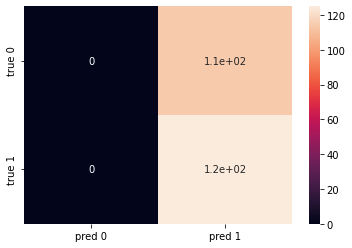

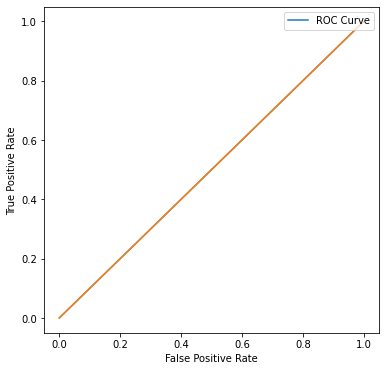

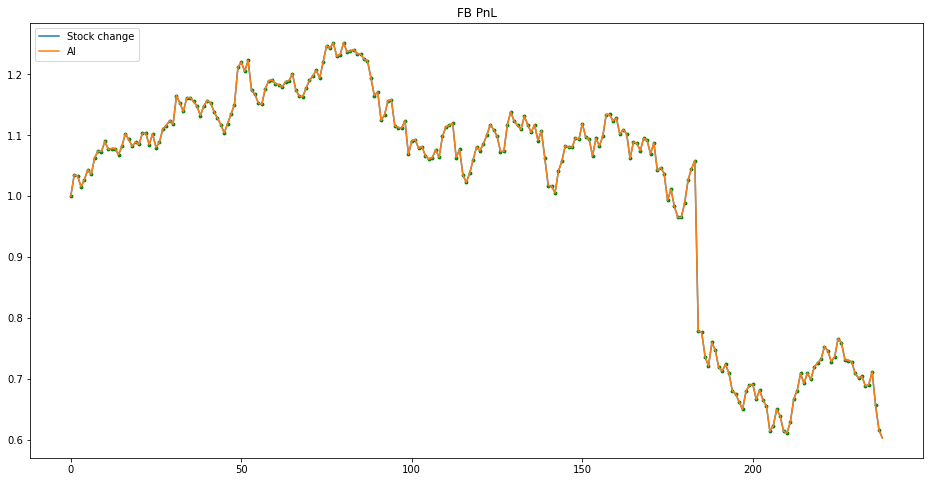

Stock change: -39.69%
Profit/Loss:  -39.69%


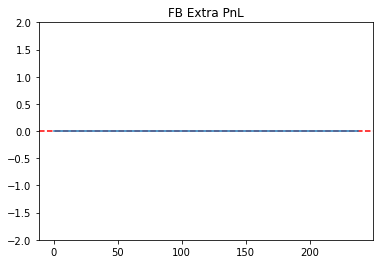

Net PnL:      -0.00%


In [10]:
test("FB")